In [1]:
%load_ext line_profiler
%load_ext autoreload

import numpy as np

import tensorflow as tf
import neural_tangents as nt
from neural_tangents import stax

from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random, jit

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Prepare data

In [2]:
# Load data from https://www.openml.org/d/554
from sklearn.datasets import fetch_openml
X_raw, y_raw = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
P = 2500 #train
P_total = int(1.5*P)

X = X_raw[:P_total]
y = (2*(y_raw.astype(int) % 2) - 1)[:P_total].reshape(-1,1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1-P/P_total, random_state=42)
len(X_train)

2499

In [5]:
from sklearn.decomposition import PCA
n_components = 10
pca = PCA(n_components = n_components)
pca = pca.fit(X_train)

In [6]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# project to hyper-sphere of radius sqrt(n_components)
X_train = np.sqrt(n_components) * X_train / np.linalg.norm(X_train, axis = 1, keepdims=True)
X_test = np.sqrt(n_components) * X_test / np.linalg.norm(X_test, axis = 1, keepdims=True)

Prepare network

In [7]:
d = n_components
N = 2*P

In [8]:
init_fn, apply_fn, kernel_fn_inf = stax.serial(
    stax.Dense(N), stax.Erf(),
)

In [9]:
initkey = random.PRNGKey(123)
_, init_params = init_fn(initkey, X_train.shape)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [10]:
apply_fn = jit(apply_fn)

train_features = apply_fn(init_params, X_train).reshape(len(X_train), -1)
test_features = apply_fn(init_params, X_test).reshape(len(X_test), -1)

In [12]:
"""
    Minimizing squared hinge loss with small regularization on the weights. 
    This gives us an L2-regularized L2-loss SVM:
        https://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf#equation.A.2
"""
import liblinear
import liblinearutil
import os

lamb = 1e-8
C = 1/(P*lamb)

#Primal (-s 2) is faster in our case
model = liblinearutil.train(y_train.reshape(-1), np.array(train_features), f'-s 2 -n {os.cpu_count()} -c {C}')

In [13]:
p_label, p_acc, p_val = liblinearutil.predict(y_train.reshape(-1), np.array(train_features), model, '-q')

Text(0.5, 1.0, 'Train: 100% accuracy')

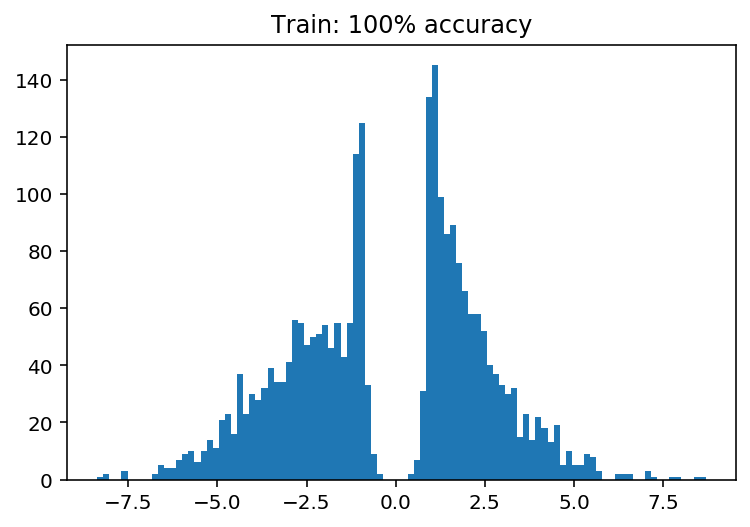

In [14]:
hist = plt.hist(np.ravel(p_val), bins = 100)
plt.title(f'Train: {p_acc[0]:.0f}% accuracy')

In [15]:
p_label, p_acc, p_val = liblinearutil.predict(y_test.reshape(-1), np.array(test_features), model, '-q')

Text(0.5, 1.0, 'Test: 91% accuracy')

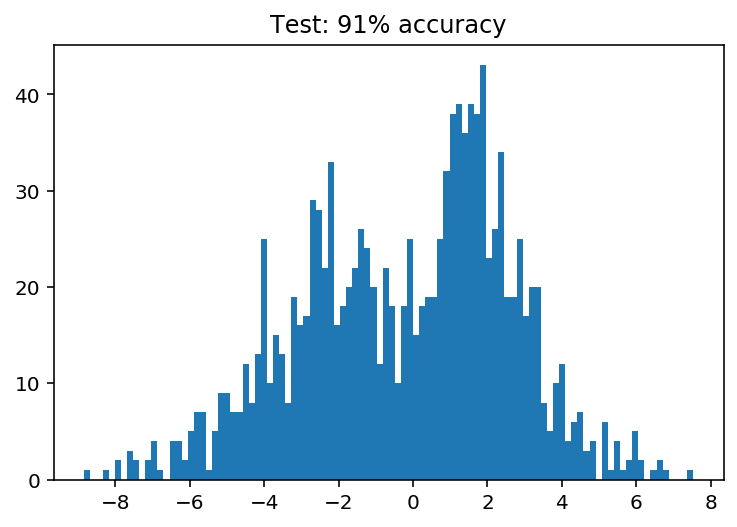

In [16]:
hist = plt.hist(np.ravel(p_val), bins = 100)
plt.title(f'Test: {p_acc[0]:.0f}% accuracy')

## Train loop

In [17]:
from tqdm import notebook as tqdm

In [23]:
results = []

for sqrt_N in tqdm.tqdm(np.arange(np.sqrt(N), 0, -1)):
    Ni = int(sqrt_N**2) #Quadratic, as if we were changing h in the NTK case
    
    init_fn, apply_fn, kernel_fn_inf = stax.serial(
        stax.Dense(Ni), stax.Erf(),
    )
    
    apply_fn = jit(apply_fn)
    _, init_params = init_fn(initkey, X_train.shape)
    
    train_features = apply_fn(init_params, X_train).reshape(len(X_train), -1)
    test_features = apply_fn(init_params, X_test).reshape(len(X_test), -1)
    
    for lamb in np.logspace(-3,-15, 5):
        C = 1/(P*lamb)
        model = liblinearutil.train(y_train.reshape(-1), np.array(train_features), f'-s 2 -n {os.cpu_count()} -c {C}')

        train_p_label, train_p_acc, train_p_val = liblinearutil.predict(y_train.reshape(-1), np.array(train_features), model, '-q')
        test_p_label, test_p_acc, test_p_val = liblinearutil.predict(y_test.reshape(-1), np.array(test_features), model, '-q')
        
        result = {
            'N': Ni,
            'P': P,
            'lambda': lamb,
            'y_train': y_train.reshape(-1),
            'y_train_hat': np.array(train_p_val).reshape(-1),
            'y_test': y_test.reshape(-1),
            'y_test_hat': np.array(test_p_val).reshape(-1)
        }
        
        results.append(result)

In [2]:
import pandas as pd

In [15]:
# result_df = pd.DataFrame(results)
# result_df.to_json(open('results/mnist_hinge_CK.json', 'w'))

In [5]:
result_df = pd.read_json(open('results/mnist_hinge_CK.json', 'r'))

In [257]:
result_df

,N,P,lambda,y_train,y_train_hat,y_test,y_test_hat,N/P,test_loss,train_loss,N_del,N_del/P,N_del/N,P/N,N_correct,N_incorrect
0,5000,2500,1.000000e-03,"[-1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1...","[-0.8150808226, 1.1775625114000001, 1.09293587...","[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, ...","[-0.0185601778, 1.521063871, 1.4513468778, -1....",2.0000,0.279654,0.026547,527,0.2108,0.1054,0.5,2491,8
1,5000,2500,1.000000e-06,"[-1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1...","[-1.0862780453, 2.114241142, 1.8587326989, -2....","[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, ...","[-0.0397618205, 2.222096634, 1.611594892, -2.4...",2.0000,0.372929,0.002573,284,0.1136,0.0568,0.5,2499,0
2,5000,2500,1.000000e-09,"[-1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1...","[-1.0900416667, 2.0606787472, 1.8610554242, -2...","[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, ...","[0.014950064400000001, 2.168355206, 1.57169478...",2.0000,0.371181,0.002787,287,0.1148,0.0574,0.5,2499,0
3,5000,2500,0.000000e+00,"[-1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1...","[-1.0089834898, 2.2460216106, 1.8940400594, -2...","[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, ...","[-0.0783128944, 2.044795374, 1.5326880225, -2....",2.0000,0.374973,0.002496,283,0.1132,0.0566,0.5,2499,0
4,5000,2500,0.000000e+00,"[-1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1...","[-1.0637964479, 2.1281855063, 1.75934902020000...","[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, ...","[-0.0751023853, 2.1639943824, 1.7158694212, -2...",2.0000,0.383654,0.002808,282,0.1128,0.0564,0.5,2499,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,2,2500,1.000000e-03,"[-1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1...","[0.13920257600000002, 0.0847240237, 0.09817990...","[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, ...","[0.0312146944, -0.101218155, -0.17044925190000...",0.0008,0.985707,0.984470,2499,0.9996,1249.5000,1250.0,1380,1119
346,2,2500,1.000000e-06,"[-1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1...","[0.1387975611, 0.0843187854, 0.0977363036, -0....","[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, ...","[0.0311625497, -0.1007945826, -0.1699204724, -...",0.0008,0.985697,0.984470,2499,0.9996,1249.5000,1250.0,1381,1118
347,2,2500,1.000000e-09,"[-1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1...","[0.13879783780000002, 0.0843189099, 0.09773645...","[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, ...","[0.0311626225, -0.1007947481, -0.1699208021000...",0.0008,0.985697,0.984470,2499,0.9996,1249.5000,1250.0,1381,1118
348,2,2500,0.000000e+00,"[-1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1...","[0.13879783810000001, 0.08431891, 0.0977364553...","[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, ...","[0.0311626225, -0.1007947483, -0.1699208025, -...",0.0008,0.985697,0.984470,2499,0.9996,1249.5000,1250.0,1381,1118


In [187]:
force = lambda y,f: 1 - y*f
loss = lambda y,f: np.mean(np.maximum(0, force(y,f))**2)
N_del = lambda y,f: np.sum(force(y,f) >= 0)
N_correct = lambda y,f: np.sum(y*f > 0)
N_incorrect = lambda y,f: np.sum(y*f < 0)

In [188]:
result_df['test_loss'] = np.vectorize(loss)(result_df.y_test, result_df.y_test_hat)
result_df['train_loss'] = np.vectorize(loss)(result_df.y_train, result_df.y_train_hat)
result_df['N_del'] = np.vectorize(N_del)(result_df.y_train, result_df.y_train_hat)

result_df['N/P'] = result_df['N']/result_df['P']
result_df['P/N'] = result_df['P']/result_df['N']
result_df['N_del/P'] = result_df['N_del']/result_df['P']
result_df['N_del/N'] = result_df['N_del']/result_df['N']


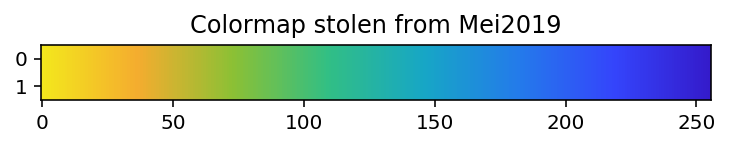

In [189]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list(
    'Mei2019', 
    np.array([
        (243, 232, 29),
        (245, 173, 47),
        (140, 193, 53),
        (50,  191, 133),
        (23,  167, 198),
        (36,  123, 235),
        (53,  69,  252),
        (52,  27,  203)
    ])/255., 
)

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig = plt.figure(figsize=(6,.5))
img = plt.imshow(gradient, aspect='auto', cmap=cmap)
title = plt.title('Colormap stolen from Mei2019')

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


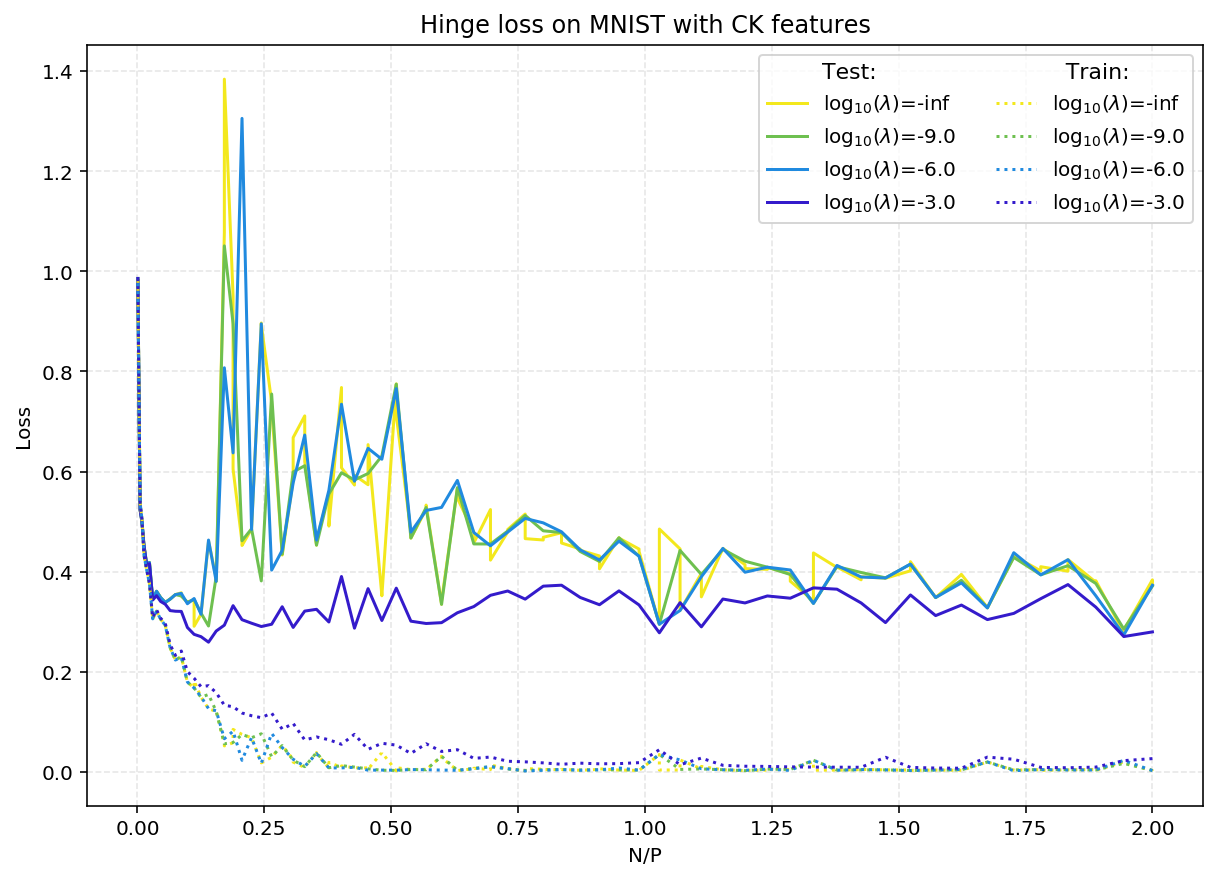

In [190]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

#Test
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N/P', 'test_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)))

#Train
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N/P', 'train_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), ls=':')

ax.legend(ncol=2, title='Test:                           Train:', title_fontsize=11)
ax.set_ylabel('Loss')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')

fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Hinge loss on MNIST with CK features')

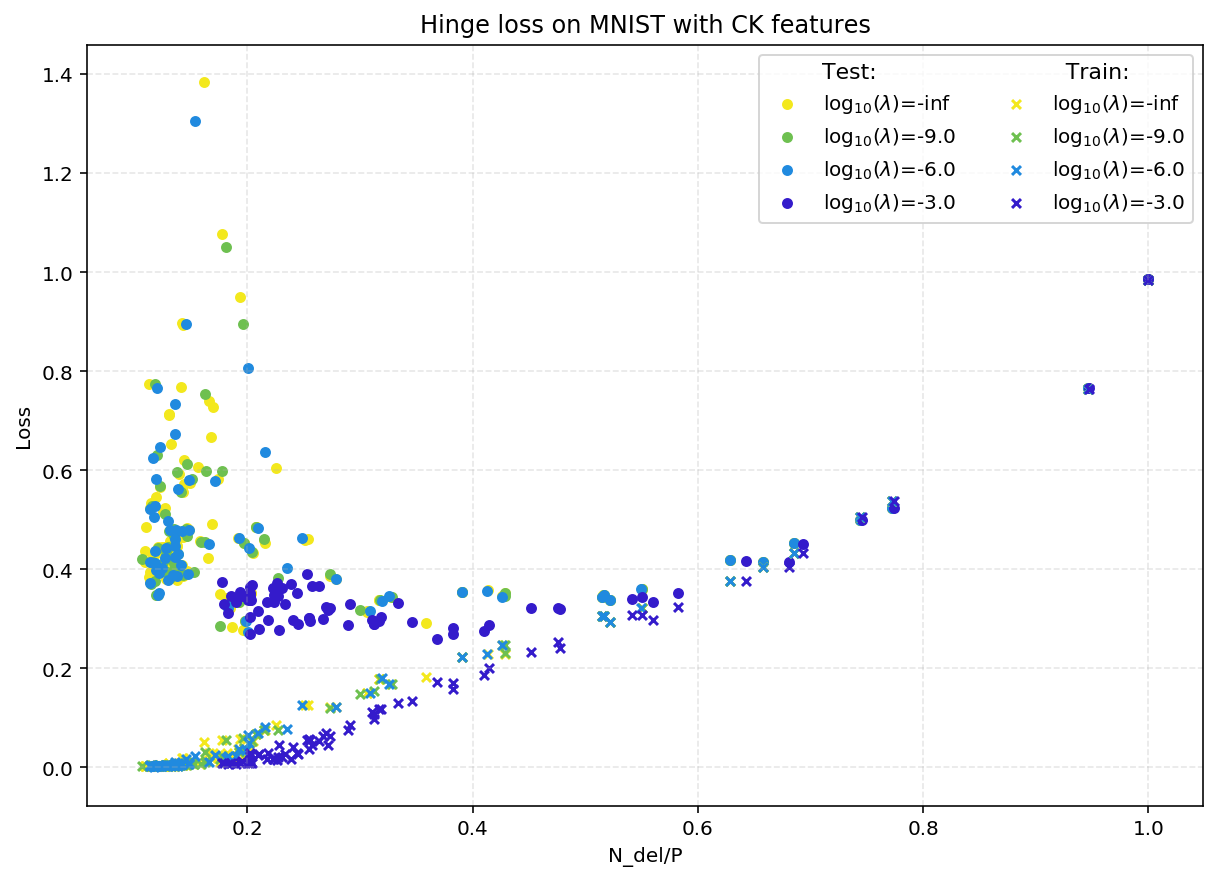

In [191]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

#Test
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/P', 'test_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

#Train
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/P', 'train_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), marker='x', kind='scatter')

ax.legend(ncol=2, title='Test:                           Train:', title_fontsize=11)
ax.set_ylabel('Loss')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')

# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


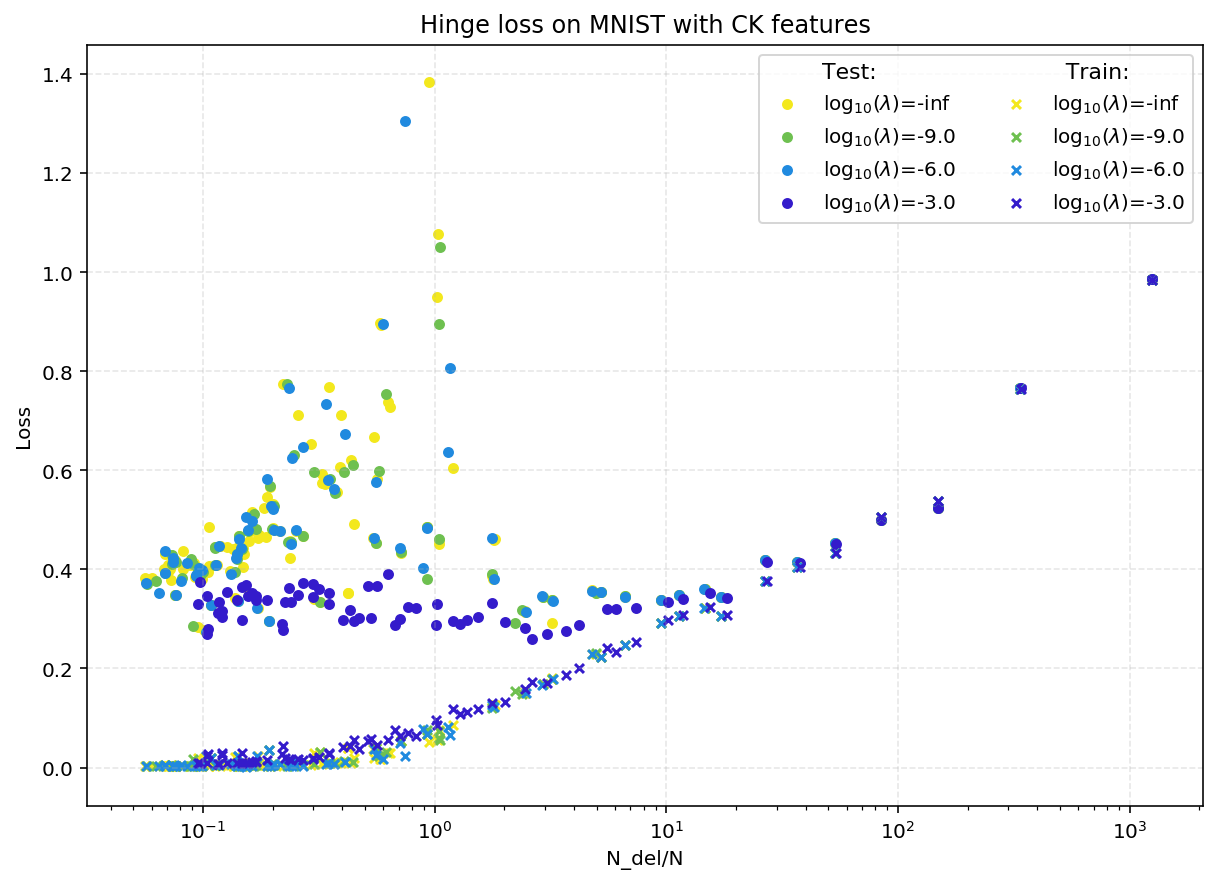

In [256]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

#Test
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/N', 'test_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

#Train
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/N', 'train_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), marker='x', kind='scatter')

ax.legend(ncol=2, title='Test:                           Train:', title_fontsize=11)
ax.set_ylabel('Loss')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')
plt.xscale('log')
# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


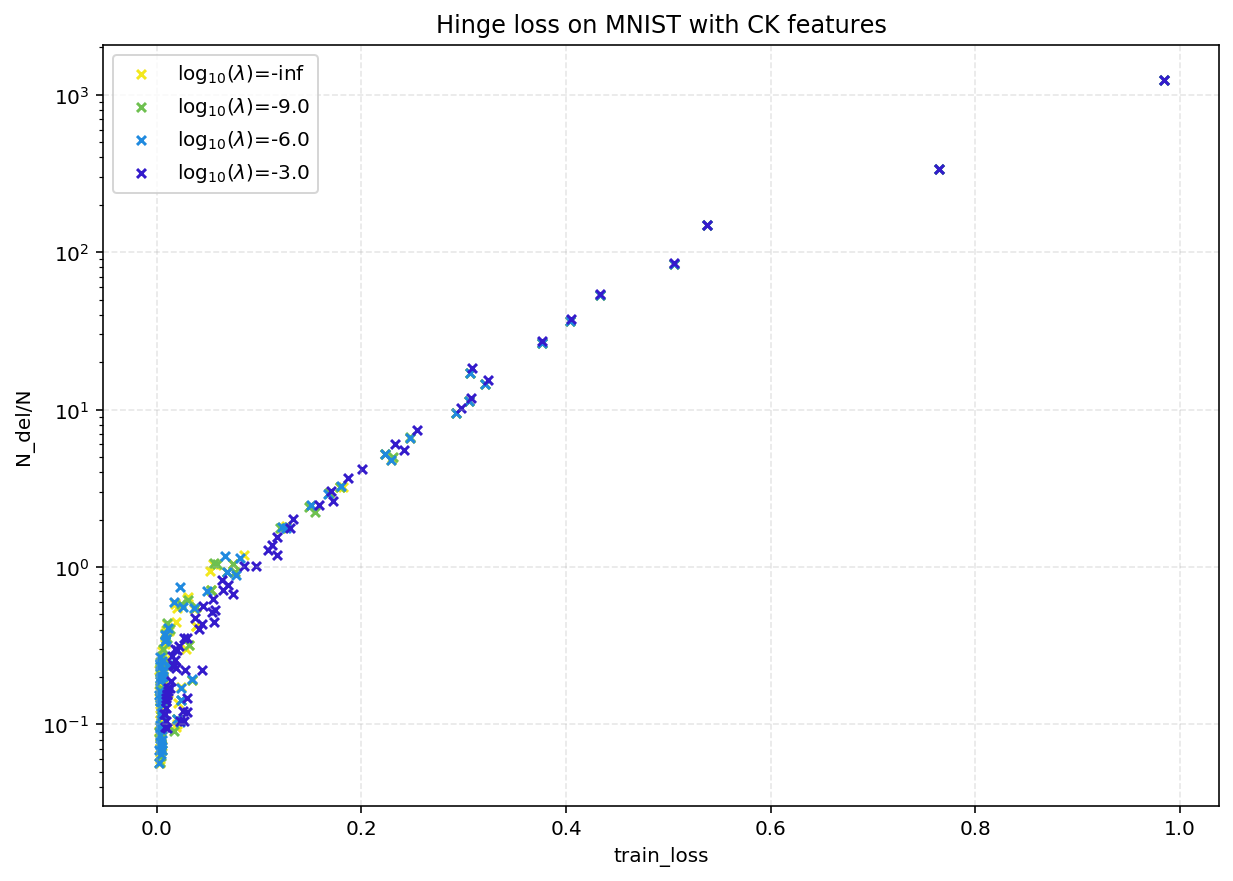

In [202]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('train_loss', 'N_del/N', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), marker='x', kind='scatter')

ax.legend()
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')
plt.yscale('log')
# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


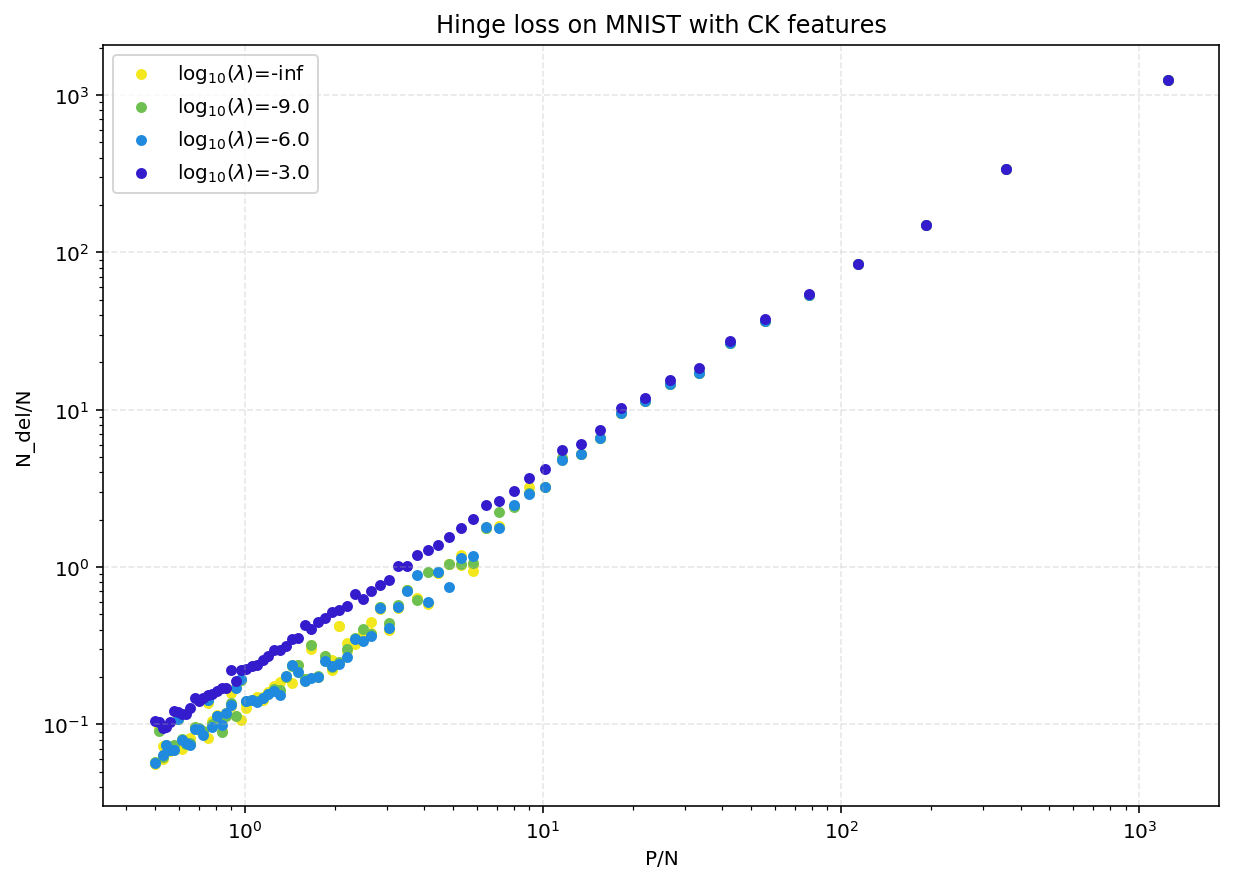

In [209]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('P/N', 'N_del/N', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

ax.legend()
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')
plt.xscale('log')
plt.yscale('log')
# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


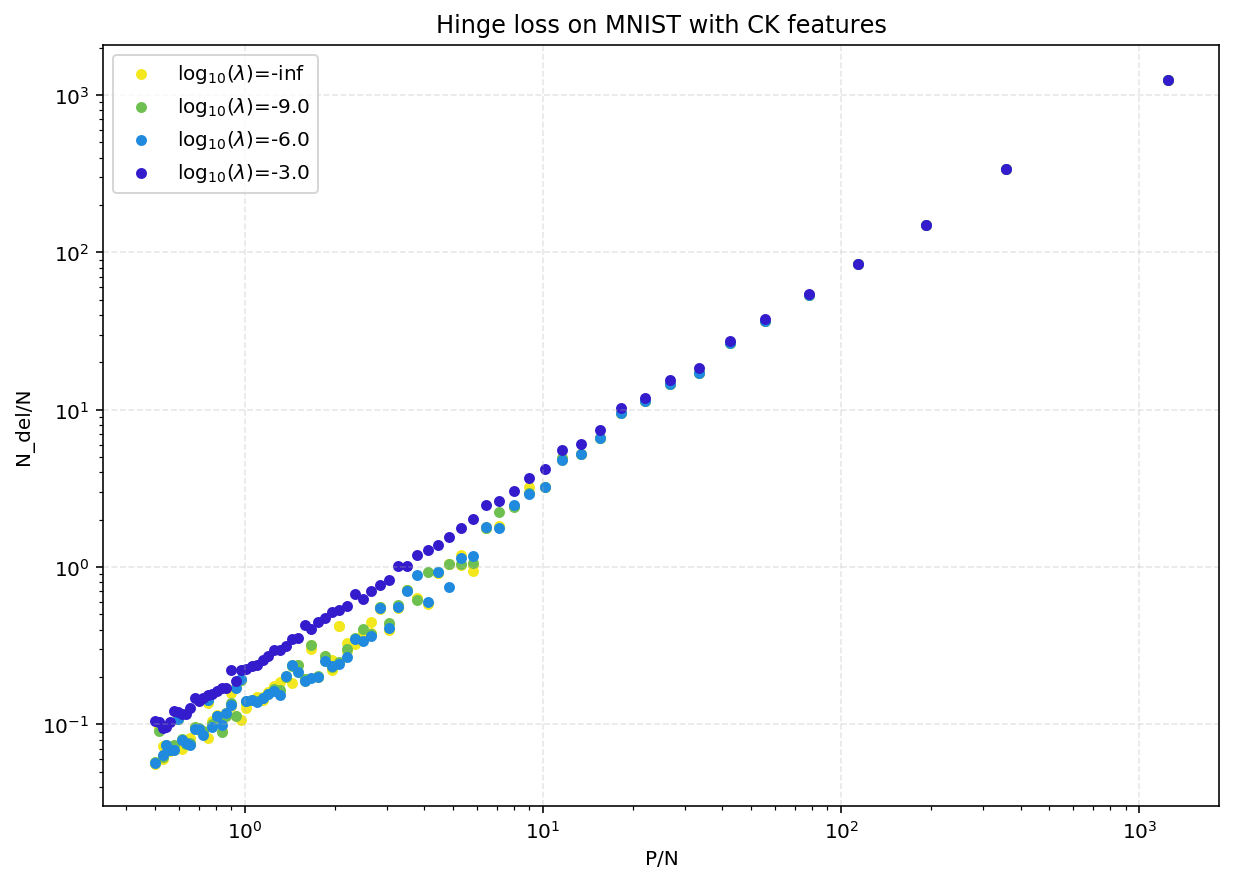

In [250]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('P/N', 'N_del/N', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')
# for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
#     df.plot('P/N', 'test_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

ax.legend()
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')
plt.yscale('log')
plt.xscale('log')

# plt.xlim(.5,10)
# plt.ylim(.05,7)
# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


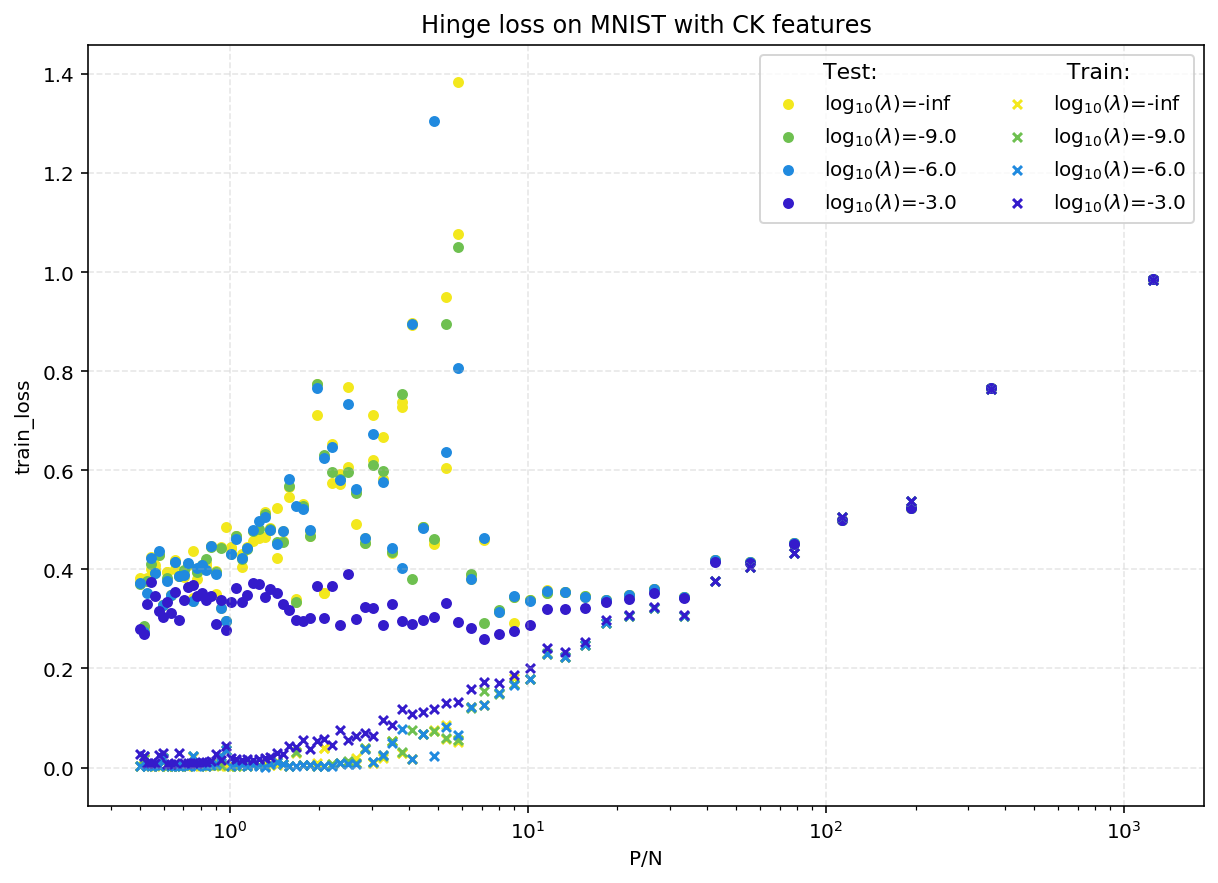

In [193]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

#Test
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('P/N', 'test_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

#Train
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('P/N', 'train_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), marker='x', kind='scatter')

ax.legend(ncol=2, title='Test:                           Train:', title_fontsize=11)
# ax.set_ylabel('Loss')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')
plt.xscale('log')
# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


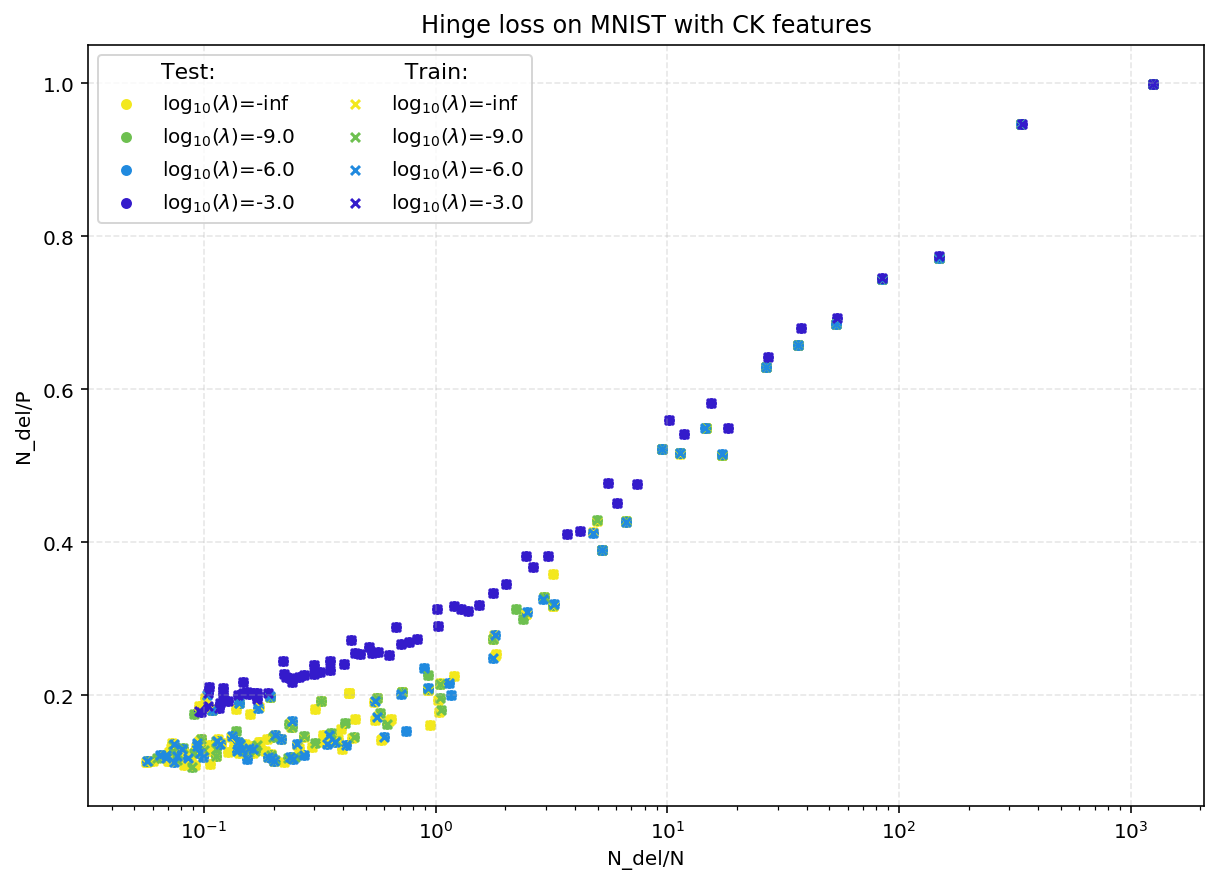

In [194]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

#Test
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/N', 'N_del/P', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

#Train
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/N', 'N_del/P', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), marker='x', kind='scatter')

ax.legend(ncol=2, title='Test:                           Train:', title_fontsize=11)
# ax.set_ylabel('Loss')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')
plt.xscale('log')
# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)